# Building a basic chatbot with langraph (GRAPH API)

In [40]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages


In [41]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)


In [42]:
graph_builder

In [43]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [44]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.1-8b-instant")

In [45]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000205FAFE0410>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000205FAFE1090>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [46]:
#Node functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

# START [Edge] ---------> Chatbot [NODE] --------> END [Edge]

In [47]:
graph_builder=StateGraph(State)

#Adding nodes
graph_builder.add_node("llmchatbot",chatbot) #First paramter it is just name and second parameter we pass our node we created above

#Adding edges
graph_builder.add_edge(START,"llmchatbot") #From start it will go to llmchatbot
graph_builder.add_edge("llmchatbot",END)   # from llmchatbpt it will go to end

#Compile the graph
graph = graph_builder.compile()

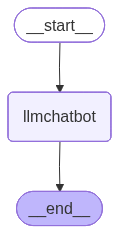

In [48]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

In [49]:
response=graph.invoke({"messages":"Hi"})

In [50]:
response["messages"][-1].content

'How can I assist you today?'

# CHATBOT WITH TOOL

In [51]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2)

tool.invoke("What is Langgraph")

{'query': 'What is Langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [52]:
# Custom Function
def multiply(a:int, b:int)->int:
    """Multiply a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a * b

In [53]:
tools=[tool,multiply]

In [54]:
llm_with_tools=llm.bind_tools(tools)

In [55]:
llm_with_tools #it contains binded tools(travily and custom mul)

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000205FAFE0410>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000205FAFE1090>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A

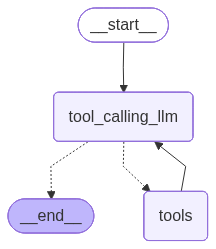

In [56]:
## StateGraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    #if the latest message (result) from assistant is a tool call -> tool_condition routes to tools
    #if the latest message (result) from assistant is a tool call -> tool_condition routes to END
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")

#Compile the graph
graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [57]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [58]:
response

{'messages': [HumanMessage(content='What is the recent ai news', additional_kwargs={}, response_metadata={}, id='7061c669-c9e8-4b60-9486-7c8e6937ef00'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'kdgjhvb4b', 'function': {'arguments': '{"query":"Recent AI news","start_date":"2023-12-25","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'b8g1s4kpc', 'function': {'arguments': '{"query":"Recent AI news","start_date":"2023-12-25","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'kvc4d9hxv', 'function': {'arguments': '{"query":"Recent AI news","start_date":"2023-12-25","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'z3a5gfgjc', 'function': {'arguments': '{"query":"Recent AI news","start_date":"2023-12-25","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'ez0tb2zjr', 'function': {'arguments': '{"query":"

In [59]:
response["messages"][-1].content

'The recent AI news is about the rise of predictive AI in hospitals, with 71% of hospitals now using it. Additionally, technology is becoming a new strategic priority for luxury houses, with some companies using AI as a creative tool and others using it to consolidate their market positioning.'

In [60]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (kdgjhvb4b)
 Call ID: kdgjhvb4b
  Args:
    query: Recent AI news
    start_date: 2023-12-25
    time_range: day
    topic: news
  tavily_search (b8g1s4kpc)
 Call ID: b8g1s4kpc
  Args:
    query: Recent AI news
    start_date: 2023-12-25
    time_range: day
    topic: news
  tavily_search (kvc4d9hxv)
 Call ID: kvc4d9hxv
  Args:
    query: Recent AI news
    start_date: 2023-12-25
    time_range: day
    topic: news
  tavily_search (z3a5gfgjc)
 Call ID: z3a5gfgjc
  Args:
    query: Recent AI news
    start_date: 2023-12-25
    time_range: day
    topic: news
  tavily_search (ez0tb2zjr)
 Call ID: ez0tb2zjr
  Args:
    query: Recent AI news
    start_date: 2023-12-25
    time_range: day
    topic: news
  tavily_search (s0xcd4230)
 Call ID: s0xcd4230
  Args:
    query: Recent

In [61]:
response=graph.invoke({"messages":"What is 2 multiplied by 3"})

In [62]:
response

{'messages': [HumanMessage(content='What is 2 multiplied by 3', additional_kwargs={}, response_metadata={}, id='f137a4bb-9859-49d2-bcb2-8eb4c5fbcf17'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '04ybmm70n', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1884, 'total_tokens': 1903, 'completion_time': 0.030015804, 'prompt_time': 0.113698129, 'queue_time': 0.0498543, 'total_time': 0.143713933}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c54ae48ece', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d8f2ca31-5d03-485a-a155-fe57ee5341ce-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': '04ybmm70n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1884, 'output_tokens': 19, 'total_tokens': 1903}),
  ToolMessage(content='6', name='multiply', id='6cd70c14-3c51-43ef-9f4a-b05

In [63]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiplied by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (04ybmm70n)
 Call ID: 04ybmm70n
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of the multiplication is 6.


In [64]:
response=graph.invoke({"messages":"What is the recent ai news and What is 2 multiplied by 3"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news and What is 2 multiplied by 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search (c33maamn1)
 Call ID: c33maamn1
  Args:
    query: recent AI news
    time_range: month
    topic: news
  multiply (jm6ykttbd)
 Call ID: jm6ykttbd
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.startupecosystem.ca/news/goodfood-ceo-steps-down-amid-operational-review-and-losses/", "title": "Goodfood CEO Steps Down Amid Operational Review and Losses - Startup Ecosystem Canada", "score": 1.0, "published_date": "Tue, 26 Aug 2025 04:09:12 GMT", "content": "## Goodfood CEO Steps Down Amid Operational Review and Losses Jonathan Ferrari, the co-founder 

In [65]:
response=graph.invoke({"messages":"Hello, my name is vaish"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is vaish
================================== Ai Message ==================================

Nice to meet you, Vaish. Is there something I can help you with today?


In [66]:
response=graph.invoke({"messages":"Hello, What is my name"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, What is my name
================================== Ai Message ==================================

I don't have any information about your name. I'm a large language model, I don't have personal relationships or access to personal data, so I won't be able to recall or retrieve any information about you. If you'd like to share your name, I'd be happy to chat with you, though!


In [67]:
# So for above situations we add memory in our graph

# Adding memory in Agentic Graph

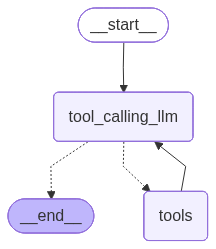

In [68]:
## StateGraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    #if the latest message (result) from assistant is a tool call -> tool_condition routes to tools
    #if the latest message (result) from assistant is a tool call -> tool_condition routes to END
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")

# Attach to your graph with memory when compiling
graph=builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))



In [71]:
config={"configurable":{"thread_id":"1"}}

response = graph.invoke({"messages":"Hi my name is vaish"},config=config)

In [72]:
response["messages"][-1].content

'Hello Vaish, how can I assist you today?'

In [73]:
response = graph.invoke({"messages":"Hi what is my name"},config=config)

response["messages"][-1].content

'Your name is Vaish.'

In [74]:
response = graph.invoke({"messages":"Hi do you remember about me"},config=config)

response["messages"][-1].content

"Yes, I remember that your name is Vaish. We had a conversation earlier, but I don't have any specific context or details about our previous conversation. Would you like to continue talking about something in particular or start fresh?"

# Streaming

Methods: .stream() and astream()

These methods are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state

values : This streams the full state of the graph after each node is called.
updates : This streams updates to the state of the graph after each node is called.

In [80]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [81]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

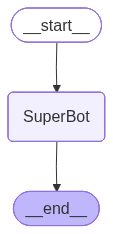

In [82]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [83]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is vaish And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is vaish And I like cricket', additional_kwargs={}, response_metadata={}, id='93a4e2a0-f9d0-48c3-8111-badda3a6c1f5'),
  AIMessage(content='Nice to meet you, Vaish. Cricket is a popular sport, especially in India. Which team is your favorite in the Indian Premier League (IPL) or international cricket?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 46, 'total_tokens': 83, 'completion_time': 0.055255543, 'prompt_time': 0.002320467, 'queue_time': 0.049168153, 'total_time': 0.05757601}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c54ae48ece', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--5fbbfa29-b391-40a2-87c2-3f29412c656f-0', usage_metadata={'input_tokens': 46, 'output_tokens': 37, 'total_tokens': 83})]}

In [84]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is vaish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Nice to meet you, Vaish! Cricket is a fantastic sport, and there are many exciting aspects to it. Are you a fan of a particular team or player? Do you prefer watching Test matches, One-Day Internationals (ODIs), or Twenty20 (T20) games?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 46, 'total_tokens': 106, 'completion_time': 0.093354609, 'prompt_time': 0.002274558, 'queue_time': 0.049745673, 'total_time': 0.095629167}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8a13dfab2b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3aaa6fc2-2bb3-4405-8757-ac1efc7a7f8a-0', usage_metadata={'input_tokens': 46, 'output_tokens': 60, 'total_tokens': 106})]}}


In [85]:
for chunk in graph_builder.stream({'messages':"Hi,My name is vaish And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is vaish And I like cricket', additional_kwargs={}, response_metadata={}, id='65445cfd-8db6-46e2-8e85-4276d5b78eb4'), AIMessage(content='Nice to meet you, Vaish! Cricket is a fantastic sport, and there are many exciting aspects to it. Are you a fan of a particular team or player? Do you prefer watching Test matches, One-Day Internationals (ODIs), or Twenty20 (T20) games?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 46, 'total_tokens': 106, 'completion_time': 0.093354609, 'prompt_time': 0.002274558, 'queue_time': 0.049745673, 'total_time': 0.095629167}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8a13dfab2b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3aaa6fc2-2bb3-4405-8757-ac1efc7a7f8a-0', usage_metadata={'input_tokens': 46, 'output_tokens': 60, 'total_tokens': 106}), HumanMessage(content='Hi,My name is vaish And I like crick

In [86]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Krish and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'fb6fb530-2d34-40f7-a056-a58a42023fc5', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Krish and I like to play cricket', additional_kwargs={}, response_metadata={}, id='84dd0418-2d6b-4f8e-8bcb-3a67b11caba2')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': 'b3d65a0b-1504-441a-952d-39fb278fba74', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:7c765601-9ef3-570c-ba15-090353cfc0e6'}, 'parent_ids': ['fb6fb530-2d34-40f7-a056-a58a42023fc5']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Krish and I like to pla

# Human in the loop

In [88]:
import os
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000205FAEEFED0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000205FB356710>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [89]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [90]:

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

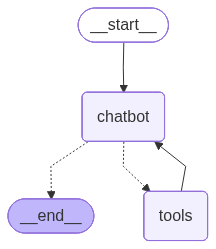

In [91]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [93]:

user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (ppm15cd1z)
 Call ID: ppm15cd1z
  Args:
    query: request assistance for building an AI agent


In [94]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (ppm15cd1z)
 Call ID: ppm15cd1z
  Args:
    query: request assistance for building an AI agent
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (074w3879y)
 Call ID: 074w3879y
  Args:
    query: building AI agents with LangGraph
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "building AI agents with LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.getzep.com/ai-agents/langgraph-tutorial/", 